# Derivations
Specifically of discretizing and linearizing continuous time dynamics as well as quadraticizing costs.

References:
1. [Jackson, Howell - iLQR Tutorial](http://roboticexplorationlab.org/papers/iLQR_Tutorial.pdf)
1. [Kavuncu et. al. - Potential iLQR](https://arxiv.org/pdf/2107.04926.pdf)
1. [Pyomo - 2.6 Model Predictive Control of a Double Integrator](https://jckantor.github.io/ND-Pyomo-Cookbook/02.06-Model-Predictive-Control-of-a-Double-Integrator.html)
1. [Discretizing an SSM](https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models)
1. [Drake - ilqr_driving](https://colab.research.google.com/github/RussTedrake/underactuated/blob/master/exercises/trajopt/ilqr_driving/ilqr_driving.ipynb#scrollTo=WCdJhqQqHLii)
1. [Al - Augmenting an Angular State](https://github.com/anassinator/ilqr/blob/master/ilqr/examples/cartpole.py)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from IPython.display import display, Math

In [8]:
%matplotlib ipympl
np.set_printoptions(precision=3, suppress=True)

## Dynamical System [1]
A dynamical system can be modeled by the following non-linear, continuous dynamics:

$$\dot x = f_c(x, u)$$

Discretizing using the [following method](https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models):

$$x_{k+1} = f(x_k, u_k)$$

Using a 1st order Taylor Series expansion, we linearize around an operating point:

$$\begin{aligned}
x_{k+1} + \delta x_{k+1} &\approx f(x_k, u_k) + 
\left.\frac{\partial f}{\partial x}\right|_{x_k, u_k}(x - x_k) + 
\left.\frac{\partial f}{\partial u}\right|_{x_k, u_k}(u - u_k)
\\
\delta x_{k+1} &= A \delta x_k + B \delta u_k
\end{aligned}
$$

In [1]:
def discretize(A, B, Δt):
    """Compute the discretization of continuous dynamics assuming zero-order hold."""
    
    k, t = sym.symbols('k t')
    Ad = sym.exp(A * Δt).simplify()
    # Ad_approx = sym.summation(1/sym.factorial(k) * (A*Δt) ** k, (k, 0, sym.oo))
    Ad_approx = sym.eye(A.shape[0], A.shape[0]) + A * Δt
    # Bd = A**-1 * (Ad - sym.eye(4,4)) * B # for non-singular A
    Bd = sym.integrate(Ad, (t, 0, Δt)) * B
    
    return Ad, Bd

In [2]:
def linearize(x_dot, x, u):
    """Compute the linearization of the dynamics with respect to x and u."""
    
    A = x_dot.jacobian(x)
    B = x_dot.jacobian(u)
    return A, B

## Unicycle Dynamics [2]
A unicycle can be modelled using the following continuous dynamics:

$$\begin{aligned}
x &= \begin{bmatrix} p_x & p_y & v & \theta \end{bmatrix} \\
u &= \begin{bmatrix} a & \omega\end{bmatrix}
\end{aligned}$$


$$\begin{aligned}
\dot p_{x} &= v\cos\theta \\
\dot p_{y} &= v\sin\theta \\
\dot \theta &= \omega \\
\dot v &= a
\end{aligned}$$

In [3]:
from decentralized import DoubleIntDynamics4D
import torch

In [4]:
m = DoubleIntDynamics4D(1)
xi = torch.zeros(4)
ui = torch.tensor([1., 0.])
m(xi, ui)

tensor([0., 0., 1., 0.])

In [5]:
theta = 0.0
dt = 1.0
v = 3.0

In [9]:
%%timeit
np.array([
    [1, 0, dt*np.cos(theta), -dt*v*np.sin(theta)],
    [0, 1, dt*np.sin(theta),  dt*v*np.cos(theta)],
    [0, 0,                     1,                        0],
    [0, 0,                     0,                        1]
])

6.57 µs ± 359 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [10]:
p_x, p_y, v, theta, omega, a = sym.symbols('p_x p_y v theta omega a')
x = sym.Matrix([p_x, p_y, v, theta])
u = sym.Matrix([a, omega])

x_dot = sym.Matrix([
    x[2]*sym.cos(x[3]),
    x[2]*sym.sin(x[3]),
    u[0],
    u[1],
])

A = x_dot.jacobian(x)
B = x_dot.jacobian(u)

A_num = sym.lambdify((x, u), A)
xi = np.array([1, 2, 3, 0])
ui = np.array([1, 1])

In [11]:
# f = sym.lambdify((x, u), sym.reshape(x_dot, (x.shape[0],)))
# f = sym.lambdify((x, u), x_dot.vec())
f = sym.lambdify((x, u), x_dot)
f0 = sym.lambdify((x, u), sym.Array(x_dot))
f = sym.lambdify((x, u), sym.Array(x_dot)[:,0])
f2 = sym.lambdify((x, u), sym.Array(x_dot).reshape(x.shape[0]))
f3 = sym.lambdify((x, u), x_dot[:,0])


In [12]:
x_dot

Matrix([
[v*cos(theta)],
[v*sin(theta)],
[           a],
[       omega]])

In [13]:
f3(xi, ui)

array([[3.],
       [0.],
       [1.],
       [1.]])

In [14]:
%timeit f(xi, ui)
%timeit f0(xi, ui)
%timeit f1(xi, ui)
%timeit f2(xi, ui)

10.6 µs ± 383 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
11.8 µs ± 342 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


NameError: name 'f1' is not defined

In [11]:
Δt = sym.Symbol('\Delta t')
p_x, p_y, v, theta, omega, a = sym.symbols('p_x p_y v theta omega a')

x = sym.Matrix([p_x, p_y, v, theta])
u = sym.Matrix([a, omega])
display(Math('x = ' + sym.latex(x) + 'u = ' + sym.latex(u)))

<IPython.core.display.Math object>

In [12]:
x_dot = sym.Matrix([
    x[2]*sym.cos(x[3]),
    x[2]*sym.sin(x[3]),
    u[0],
    u[1],
])

A, B = linearize(x_dot, x, u)
print('Continuous Time:')
display(Math('A = ' + sym.latex(A) + '\; B = ' + sym.latex(B)))

Ad, Bd = discretize(A, B, Δt)
print('Discrete Time:')
display(Math('A_d = ' + sym.latex(Ad)))
display(Math('B_d = \Delta t ' + sym.latex(Bd/Δt)))

print('Others:')
Bo = sym.Matrix([[0, 0], [0, 0], [Δt, 0], [0, Δt]])
display(Math('B = \Delta t' + sym.latex(Bo/Δt)))

Continuous Time:


<IPython.core.display.Math object>

Discrete Time:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Others:


<IPython.core.display.Math object>

## Car Dynamics
- "car" dynamics represent a simplified version of the unicycle dynamics where the linear velocity is in the control, rather than the state.
$$\begin{aligned}
x &= \begin{bmatrix} p_x & p_y & \theta \end{bmatrix} \\
u &= \begin{bmatrix} v & \omega\end{bmatrix}
\end{aligned}$$


$$\begin{aligned}
\dot p_{x} &= v\cos\theta \\
\dot p_{y} &= v\sin\theta \\
\dot \theta &= \omega \\
\end{aligned}$$

In [52]:
np.sqrt(2)/2

0.7071067811865476

In [47]:
np.cos(np.pi/4)

0.7071067811865476

In [35]:
delta_t = sym.Symbol('\Delta t')
p_x, p_y, v, theta, omega = sym.symbols('p_x p_y v theta omega')

x = sym.Matrix([p_x, p_y, theta])
u = sym.Matrix([v, omega])
display(Math('x = ' + sym.latex(x)))
display(Math('u = ' + sym.latex(u)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [45]:
np.eye(4, 2, -2).astype(int)

array([[0, 0],
       [0, 0],
       [1, 0],
       [0, 1]])

In [43]:
np.diag([1,1,], 2)

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [40]:
x_dot.jacobian(u)

Matrix([
[cos(theta), 0],
[sin(theta), 0],
[         0, 1]])

In [42]:
x_dot = sym.Matrix([
    u[0]*sym.cos(x[2]),
    u[0]*sym.sin(x[2]),
    u[1],
])

A, B = linearize(x_dot, x, u)
print('Continuous time:')
display(Math('A = ' + sym.latex(A) + '\;B = ' + sym.latex(B)))

Ad, Bd = discretize(A, B, Δt)
print('Discrete Time:')
display(Math('A_d = ' + sym.latex(Ad) + '\;B_d = \Delta t ' + sym.latex(Bd/Δt)))

Continuous time:


<IPython.core.display.Math object>

Discrete Time:


<IPython.core.display.Math object>

## Bicycle Dynamics [5]
- We can add an additional component to the standard car/unicycle dynamics via steering.
- Letting $\phi$ be the steering angle, the dynamics are:
$$\begin{aligned}
x &= \begin{bmatrix} p_x & p_y & v & \theta & \phi \end{bmatrix} \\
u &= \begin{bmatrix} a & \rho\end{bmatrix}
\end{aligned}$$


$$\begin{aligned}
\dot p_{x} &= v\cos\theta \\
\dot p_{y} &= v\sin\theta \\
\dot v &= a \\
\dot \phi &= \rho \\
\end{aligned}$$

In [55]:
delta_t = sym.Symbol('\Delta t')
p_x, p_y, theta, v, phi, a, rho = sym.symbols('p_x p_y theta v phi a rho')

x = sym.Matrix([p_x, p_y, v, theta, phi])
u = sym.Matrix([a, rho])
display(Math('x = ' + sym.latex(x) + '\;u = ' + sym.latex(u)))

<IPython.core.display.Math object>

In [56]:
x_dot = sym.Matrix([
    x[2]*sym.cos(x[3]),
    x[2]*sym.sin(x[3]),
    u[0],
    x[2]*sym.tan(x[4]),
    u[1]
])

A, B = linearize(x_dot, x, u)
print('Continuous time:')
display(Math('A = ' + sym.latex(A) + '\;B = ' + sym.latex(B)))

Ad, Bd = discretize(A, B, Δt)
print('Discrete Time:')
display(Math('A_d = ' + sym.latex(Ad)))
display(Math('B_d = \Delta t ' + sym.latex(Bd/Δt)))

Continuous time:


<IPython.core.display.Math object>

Discrete Time:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [22]:
Bd.simplify()
Bd / Δt

Matrix([
[\Delta t*(-\Delta t*v*sin(theta)*tan(phi)/2 + cos(theta)), -\Delta t**2*v**2*sin(theta)/(2*cos(phi)**2)],
[ \Delta t*(\Delta t*v*cos(theta)*tan(phi)/2 + sin(theta)),  \Delta t**2*v**2*cos(theta)/(2*cos(phi)**2)],
[                                                        1,                                            0],
[                                        \Delta t*tan(phi),                       \Delta t*v/cos(phi)**2],
[                                                        0,                                            1]])

## Double Integrator Dynamics [3]
- The double integrator model is a canonical second order linear system often used to demostrate control principles. 
- This can be represented in the discretized equation as:
$$x_{k+1} = A x_k + B u_k 
= \begin{bmatrix} 1 & \Delta t \\ 0 & 1\end{bmatrix} x_k + \begin{bmatrix} \frac{\Delta t^2}{2} \\ \Delta t \end{bmatrix} u_k$$

In [19]:
# dt = sym.Symbol('\Delta t')
dt, p_x, p_y, v_x, v_y, a_x, a_y = sym.symbols('dt p_x p_y v_x v_y a_x a_y')

x = sym.Matrix([p_x, v_x])
u = sym.Matrix([a_x])
display(Math('x = ' + sym.latex(x) + '\;u = ' + sym.latex(u)))

<IPython.core.display.Math object>

In [28]:
x_dot = sym.Matrix([
    v_x + a_x*dt,
    # v_y + a_y*Δt,
    a_x,
    # a_y
])

A = x_dot.jacobian(x)
B = x_dot.jacobian(u)
B

Matrix([
[dt],
[ 1]])

## Augmented Unicycle Dynamics [2]
A unicycle can be modelled using the following augmented continuous dynamics:

$$\begin{aligned}
x &= \begin{bmatrix} p_x & p_y & v & \sin(\theta) & \cos(\theta) \end{bmatrix} \\
u &= \begin{bmatrix} a & \omega\end{bmatrix}
\end{aligned}$$


$$\begin{aligned}
\dot p_{x} &= v\cos\theta \\
\dot p_{y} &= v\sin\theta \\
\dot \theta &= \omega \\
\dot v &= a
\end{aligned}$$

In [26]:
Δt = sym.Symbol('\Delta t')
sθ = sym.Symbol('\sin \Theta')
cθ = sym.Symbol('\cos \Theta')
p_x, p_y, v, omega, a = sym.symbols('p_x p_y v omega a')

x = sym.Matrix([p_x, p_y, v, sθ, cθ])
u = sym.Matrix([a, omega])
display(Math('x = ' + sym.latex(x) + '\;u = ' + sym.latex(u)))

<IPython.core.display.Math object>

In [ ]:
x_dot = sym.Matrix([
    x[2]*x[4],
    x[2]*x[3],
    u[0],
    u[1]*x[4], # sym.sin(u[1]),
    -u[1]*x[3] # sym.cos(u[1])
])

A, B = linearize(x_dot, x, u)
print('Continuous Time:')
display(Math('A = ' + sym.latex(A) + '\;B = ' + sym.latex(B)))

Ad, Bd = discretize(A, B, Δt)
print('Discrete Time:')
display(Math('A_d = ' + sym.latex(Ad) + '\;B_d = \Delta t ' + sym.latex(Bd/Δt)))

print('Others:')
Bo = sym.Matrix([[0, 0], [0, 0], [Δt, 0], [0, Δt]])
display(Math('B = \Delta t' + sym.latex(Bo/Δt)))

Continuous Time:


<IPython.core.display.Math object>

Discrete Time:


<IPython.core.display.Math object>

Others:


<IPython.core.display.Math object>

## Quadraticizing Costs

In [27]:
def quadraticize(L, x, u):
    """Quadraticize the costs with respect to the states and controls."""
    
    L_x = L.jacobian(x)
    L_u = L.jacobian(u)
    L_xx = L_x.jacobian(x)
    L_uu = L_u.jacobian(u)
    L_xu = L_x.jacobian(u)
    L_ux = L_u.jacobian(x)
    
    return L_x, L_u, L_xx, L_uu, L_xu, L_ux

In [28]:
def quadraticize_reference(x, u, x_r, Q, R, terminal=False):
    """Quadraticize reference costs analytically."""
    
    L_x = (x - x_r).T @ (Q + Q.T)
    L_u = u.T @ (R + R.T)
    L_xx = Q + Q.T
    L_uu = R + R.T
    L_xu = sym.zeros(x.shape[0], u.shape[0])
    L_ux = L_xu.T
    
    if terminal:
        γ = sym.symbols('gamma')
        L_x *= γ
        L_xx *= γ
        L_u = sym.zeros(1, u.shape[0])
        L_uu = sym.zeros(u.shape[0])
    
    return L_x, L_u, L_xx, L_uu, L_xu, L_ux

In [32]:
delta_t = sym.Symbol('\Delta t')
p_x, p_y, v, theta, omega, a = sym.symbols('p_x p_y v theta omega a')
p_xr, p_yr, v_r, theta_r, omega_r, a_r = sym.symbols('p_xr p_yr v_r theta_r omega_r a_r')
p_xo, p_yo = sym.symbols('p_xo p_yo')

x = sym.Matrix([p_x, p_y, v, theta])
u = sym.Matrix([omega, a])
x_r = sym.Matrix([p_xr, p_yr, v_r, theta_r])
x_o = sym.Matrix([p_xo, p_yo, 0, 0])

In [30]:
nx, nu = 4, 2
x = sym.MatrixSymbol('x', nx, 1)
u = sym.MatrixSymbol('u', nu, 1)
Q = sym.MatrixSymbol('Q', nx, nx)
R = sym.MatrixSymbol('R', nu, nu)

L = x.T @ Q @ x + u.T @ R @ u
Lx = L.diff(x)
Lu = L.diff(u)
Lxx = Lx.diff(x)
Luu = Lu.diff(u)
Lux = Lu.diff(x)

In [31]:
Q = sym.eye(x.shape[0])
R = sym.eye(u.shape[0])
# Q = sym.Matrix(np.arange(16)).reshape(4,4)
# Q = sym.diag(1, 1, 0, 0)
# Q[0,-1] = 1.0
# R = sym.diag(2.0, 1.0)
# R[0,-1] = 3.0

display(Math('Q = ' + sym.latex(Q)))
display(Math('R = ' + sym.latex(R)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [158]:
L.jacobian(x).jacobian(x)

Matrix([
[2, 0, 0, 0],
[0, 2, 0, 0],
[0, 0, 2, 0],
[0, 0, 0, 2]])

In [12]:
L = (x - x_r).T @ Q @ (x - x_r) + (u.T @ R @ u)
L_x, L_u, L_xx, L_uu, L_xu, L_ux = quadraticize(L, x, u)
L_x_a, L_u_a, L_xx_a, L_uu_a, L_xu_a, L_ux_a = quadraticize_reference(x, u, x_r, Q, R)

display(Math('L_u = ' + sym.latex(L_u) + ' = u^T (R + R^T) = ' + sym.latex(L_u_a)))
display(Math('L_x = ' + sym.latex(L_x) + ' = (x - x_r)^T (Q + Q^T)'))
display(Math('L_{xx} = ' + sym.latex(L_xx) + ' = Q + Q^T = ' + sym.latex(L_xx_a)))
display(Math('L_{uu} = ' + sym.latex(L_uu) + ' = R + R^T = ' + sym.latex(L_uu_a)))
display(Math('L_{xu} = L_{ux}^T = ' + sym.latex(L_xu_a)))

AttributeError: 'MatAdd' object has no attribute 'jacobian'

In [13]:
dL_dxu = L_x.row_join(L_u) # Gradient
dL_dxu

NameError: name 'L_x' is not defined

In [154]:
dL2_dxu2 = sym.Matrix(sym.BlockMatrix([
    [L_xx, L_xu],
    [L_xu.T, L_uu]
])) # Hessian
dL2_dxu2

Matrix([
[2, 0, 0, 0, 0, 0],
[0, 2, 0, 0, 0, 0],
[0, 0, 2, 0, 0, 0],
[0, 0, 0, 2, 0, 0],
[0, 0, 0, 0, 2, 0],
[0, 0, 0, 0, 0, 2]])

In [14]:
γ = sym.symbols('gamma')
L_N = γ * (x - x_r).T @ Q @ (x - x_r)
L_x, L_u, L_xx, L_uu, L_xu, L_ux = quadraticize(L_N, x, u)
L_x_a, L_u_a, L_xx_a, L_uu_a, L_xu_a, L_ux_a = quadraticize_reference(x, u, x_r, Q, R, terminal=True)

display(Math('L_u = ' + sym.latex(L_u) + ' = u^T (R + R^T) = ' + sym.latex(L_u_a)))
display(Math('L_x = ' + sym.latex(L_x.T) + ' = (x - x_r)^T (Q + Q^T) = ' + sym.latex(L_x_a.T)))
display(Math('L_{xx} = ' + sym.latex(L_xx) + ' = Q + Q^T = ' + sym.latex(L_xx_a)))
display(Math('L_{uu} = ' + sym.latex(L_uu) + ' = R + R^T = ' + sym.latex(L_uu_a)))
display(Math('L_{xu} = L_{ux}^T = ' + sym.latex(L_xu_a)))

AttributeError: 'MatMul' object has no attribute 'jacobian'

### Obstacle Cost
$$L = \min(0, d-d_{max})^2$$

In [33]:
from sympy.functions.elementary.piecewise import Piecewise
import matplotlib.pyplot as plt

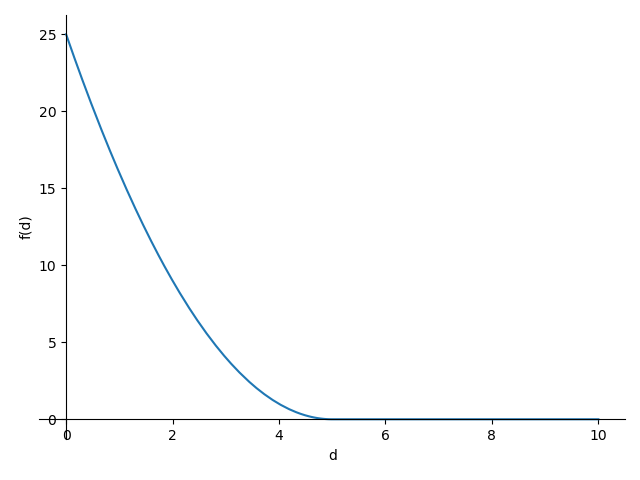

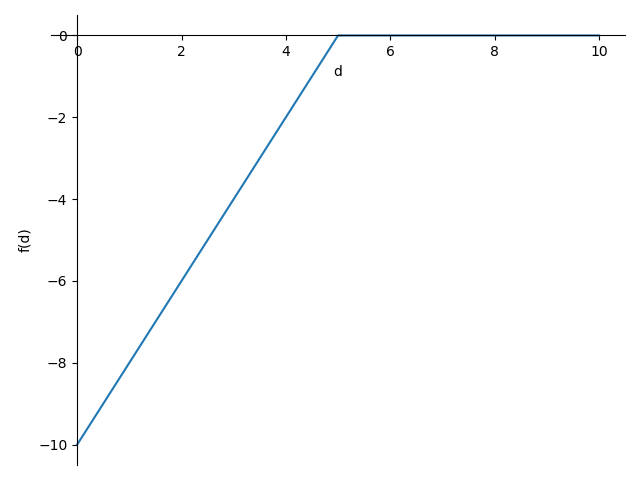

Text(0.5, 1.0, 'Lx')

In [34]:
d_max, d = sym.symbols('d_{max} d', positive=True)
L = Piecewise((0, d > d_max), ((d - d_max)**2, d <= d_max))

sym.plot(L.subs(d_max, 5), (d, 0, 10))
plt.title('L')
sym.plot(L.subs(d_max, 5).diff(d), (d, 0, 10))
plt.title('Lx')

In [38]:
a_x, a_y, b_x, b_y = sym.symbols('a_x a_y b_x b_y')
x = sym.Matrix([a_x, a_y, v, theta, b_x, b_y, v, theta])
u = sym.Matrix([a, omega])
d = sym.sqrt((a_x - b_x)**2 + (a_y - b_y)**2)
L = sym.Matrix([(d - d_max)**2])
L

Matrix([[(-d_{max} + sqrt((a_x - b_x)**2 + (a_y - b_y)**2))**2]])

In [39]:
L_x, L_u, L_xx, L_uu, L_xu, L_ux = quadraticize(L, x, u)
L_x

Matrix([[2*(a_x - b_x)*(-d_{max} + sqrt((a_x - b_x)**2 + (a_y - b_y)**2))/sqrt((a_x - b_x)**2 + (a_y - b_y)**2), 2*(a_y - b_y)*(-d_{max} + sqrt((a_x - b_x)**2 + (a_y - b_y)**2))/sqrt((a_x - b_x)**2 + (a_y - b_y)**2), 0, 0, 2*(-a_x + b_x)*(-d_{max} + sqrt((a_x - b_x)**2 + (a_y - b_y)**2))/sqrt((a_x - b_x)**2 + (a_y - b_y)**2), 2*(-a_y + b_y)*(-d_{max} + sqrt((a_x - b_x)**2 + (a_y - b_y)**2))/sqrt((a_x - b_x)**2 + (a_y - b_y)**2), 0, 0]])

In [44]:
L_xx

Matrix([
[ 2*d_{max}*(a_x - b_x)**2/((a_x - b_x)**2 + (a_y - b_y)**2)**(3/2) - 2*d_{max}/sqrt((a_x - b_x)**2 + (a_y - b_y)**2) + 2,     2*d_{max}*(a_x*a_y - a_x*b_y - a_y*b_x + b_x*b_y)/(a_x**2 - 2*a_x*b_x + a_y**2 - 2*a_y*b_y + b_x**2 + b_y**2)**(3/2), 0, 0, -2*d_{max}*(a_x - b_x)**2/((a_x - b_x)**2 + (a_y - b_y)**2)**(3/2) + 2*d_{max}/sqrt((a_x - b_x)**2 + (a_y - b_y)**2) - 2,    2*d_{max}*(-a_x*a_y + a_x*b_y + a_y*b_x - b_x*b_y)/(a_x**2 - 2*a_x*b_x + a_y**2 - 2*a_y*b_y + b_x**2 + b_y**2)**(3/2), 0, 0],
[    2*d_{max}*(a_x*a_y - a_x*b_y - a_y*b_x + b_x*b_y)/(a_x**2 - 2*a_x*b_x + a_y**2 - 2*a_y*b_y + b_x**2 + b_y**2)**(3/2),  2*d_{max}*(a_y - b_y)**2/((a_x - b_x)**2 + (a_y - b_y)**2)**(3/2) - 2*d_{max}/sqrt((a_x - b_x)**2 + (a_y - b_y)**2) + 2, 0, 0,    2*d_{max}*(-a_x*a_y + a_x*b_y + a_y*b_x - b_x*b_y)/(a_x**2 - 2*a_x*b_x + a_y**2 - 2*a_y*b_y + b_x**2 + b_y**2)**(3/2), -2*d_{max}*(a_y - b_y)**2/((a_x - b_x)**2 + (a_y - b_y)**2)**(3/2) + 2*d_{max}/sqrt((a_x - b_x)**2 + (a_y - b_y)**2)

### Obstacle Cost 2

Same as before with linear cost from $d_{max}$ to $2 d_{max}$.

In [66]:
d_max, d, gamma = sym.symbols('d_{max} d gamma', positive=True)
L = Piecewise(
    ((d - d_max)**2 + gamma, d <= d_max),
    (gamma * (2 - d/d_max), (d_max <= d) & (d <= 2 * d_max)),
    (0,  d > 2*d_max)
)

Ls = L.subs({d_max: 5, gamma: 10})

sym.plot(Ls, (d, 0, 10))
plt.title('L')
sym.plot(Ls.diff(d), (d, 0, 10))
plt.title('Lx')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Lx')